<a href="https://colab.research.google.com/github/iceaiai/CS-team/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python pillow
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=d68b333bcb0eb5a9ac7536a39e1614b639cb53a8739bd153a3ff4276139af0ba
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=49d2d004a996c9b594d43e13007e6c8957349fe036ac24556142aff161750b66
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

#1. Setup and Imports
Import all necessary libraries and ensure that the environment is correctly set up

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import *
from PIL import Image
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms, models
import os
import numpy as np
import kagglehub
import shutil


original_path = kagglehub.dataset_download("batuhanyil/electron-microscopy-particle-segmentation")
print("Original Path to dataset files:", original_path)
path = "/content/electron-microscopy-particle-segmentation"
shutil.move(original_path, path)
print(f"Dataset moved to: {path}")
!ls {path}

100%|██████████| 113M/113M [00:06<00:00, 17.8MB/s]

Extracting files...


Original Path to dataset files: /root/.cache/kagglehub/datasets/batuhanyil/electron-microscopy-particle-segmentation/versions/1
Dataset moved to: /content/electron-microscopy-particle-segmentation
images	segmaps


In [3]:
print("Contents of the dataset folder:")
print(os.listdir(path))

Contents of the dataset folder:
['images', 'segmaps']


#2.Configuration class or dictionary to make hyperparameters easily tunable
Note: 'image' folder contains SEM/TEM images. 'segmaps' contained the labelled masks.They are also available in our GT github.

In [17]:
class Config:
    # Data parameters
    image_folder = os.path.join(path, 'images')
    mask_folder = os.path.join(path, 'segmaps')
    resize = (512, 512) # it will be very painful if the image height and width are not the same!!!!

    # Training hyperparameters
    num_epochs = 50
    batch_size = 16
    learning_rate = 2e-4
    momentum = 0.9
    weight_decay = 1.5e-4

    # Model parameters
    num_classes = 1  # For binary segmentation
    kernel_size = 3
    stride = 1
    padding = 1

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f'current device = {config.device}')


current device = cuda


#3. Dataset preparation:


In [18]:
#Class for preparing data
class ImageDataset:
    def __init__(self, image_folder, mask_folder,transform =None,binary=False):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = sorted(os.listdir(image_folder))
        self.mask_files = sorted(os.listdir(mask_folder))
        self.transform = transform
        self.binary = binary
    def binary_transform(self, mask): # We only deal with one class
        # Transform mask to 1,0. 1 for masked area, 0 for not
        mask_array = np.array(mask)
        binary_mask = (mask_array != 0).astype(np.uint8)
        return Image.fromarray(binary_mask)

    def __len__(self): #Dunder method, usage: len(obj)
      return len(self.image_files)
    def __getitem__(self, idx): #Dunder method, usage: obj[idx]
      image_path = os.path.join(self.image_folder, self.image_files[idx])
      mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
      image = Image.open(image_path).convert('L')
      mask = Image.open(mask_path).convert('L')
      if self.binary:
          mask = self.binary_transform(mask)
      if self.transform:
          image, mask = self.transform(image, mask)
      return image, mask
    def plot_figure(self, overlay=False, mask=True, binary=False, idx=None):
        """
        overlay: overlapping the original and masked images
        mask: display mask images
        idx: index or list of indices of the images to plot
        """
        if idx is None:
            idx = [0]
        elif isinstance(idx, int):
            idx = [idx]
        idx = [i for i in idx if i < len(self.image_files)]
        total_cols = 3 if mask and overlay else 2 if mask else 1
        total_rows = len(idx)
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(5 * total_cols, 5 * total_rows))

        if total_rows == 1:
            axes = [axes]

        for i, file_idx in enumerate(idx):
            img, mask_img = self[file_idx]

            # Convert tensors to numpy arrays
            img_np = img.squeeze(0).numpy()  # Squeeze channel for grayscale
            mask_np = mask_img.numpy()  # mask is already single-channel after transform

            ax_row = axes[i] if total_rows > 1 else axes

            # Display the image
            ax_row[0].imshow(img_np, cmap='gray')
            ax_row[0].set_title(f"Image {self.image_files[file_idx]}")
            ax_row[0].axis('off')

            if mask:
                # Display the mask
                ax_row[1].imshow(mask_np, cmap='inferno')
                ax_row[1].set_title(f"Mask {self.mask_files[file_idx]}")
                ax_row[1].axis('off')

                if overlay:
                    # Display the overlay
                    ax_row[2].imshow(img_np, cmap='gray', alpha=0.9)
                    ax_row[2].imshow(mask_np, cmap='inferno', alpha=0.4)
                    ax_row[2].set_title(f"Overlay {file_idx}")
                    ax_row[2].axis('off')

        plt.tight_layout()
        plt.show()

#Class for transforming data:
"""
  1. Resizing;
  2. Converting to tensor;
"""
class SegmentationTransform:
    def __init__(self, resize=None):
        self.resize = resize
        self.image_resize = transforms.Resize(resize)
        self.mask_resize = transforms.Resize(resize, interpolation=Image.NEAREST)

    def __call__(self, image, mask):
        image = self.image_resize(image)
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        mask = self.mask_resize(mask)
        mask_array = np.array(mask)
        binary_mask = (mask_array > 0).astype(np.float32)
        mask_tensor = torch.tensor(binary_mask)
        return image_tensor, mask_tensor




#4. Data Loader

In [19]:
#Assign image and mask folder. Test the imagedata set class:
transform = SegmentationTransform(resize = config.resize) # can add resize if needed but not recommended
dataset = ImageDataset(config.image_folder, config.mask_folder, transform=transform, binary=True)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data loaders
"""
You can set:
batch size;
shuffle the data or not
num_workers: higher value speeding up the loading process.

"""

train_loader = DataLoader(train_dataset,
              batch_size=config.batch_size,
              shuffle=True,
              num_workers=4
              )
val_loader = DataLoader(val_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
test_loader = DataLoader(test_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )

#dataset.plot_figure(overlay=True, mask=True, binary=True,idx=[10,11,12,13,14,15,16,17,20, 21, 22, 23, 24, 25])

In [7]:
example_img1,example_mask1 = dataset[1]

example_mask1_np = np.array(example_mask1)
np.max(example_mask1_np)


1.0

# 5. Model preparation


##5.1 VGG-16


In [8]:
#Architectures of VGG-16:
"""
# input: (1,1,512,512)
(0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(1): ReLU(inplace=True)
(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(3): ReLU(inplace=True)
(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# Pool1(1,64,256,256)
(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(6): ReLU(inplace=True)
(7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(8): ReLU(inplace=True)
(9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)#Pool2 (1,128,128,128)
(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(11): ReLU(inplace=True)
(12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(13): ReLU(inplace=True)
(14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(15): ReLU(inplace=True)
(16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool3 (1,256,64,64)
(17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(18): ReLU(inplace=True)
(19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace=True)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace=True)
(23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool4(1,512,32,32)
(24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(25): ReLU(inplace=True)
(26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
(30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool5(1,512,16,16)
)
"""
#FCN only, discard FCL
class FCN8s_VGG16(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s_VGG16, self).__init__()
        vgg = models.vgg16(pretrained=True) # VGG from pytorch

        vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) #remember we only have one channel not RGB, see [0] layer above
        #features = list(vgg.features.children())
        self.features = nn.Sequential(*list(vgg.features.children()))

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1) #convert 256 to number_class=1,dimension reduction
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1) #convert 512 to 1
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)  #convert 512 to 1

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2) #upsample to original data size *2
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2)#upsample to original data size *2
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, 8, stride=8)#upsample to original data size *8

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)
        score_fr = self.score_fr(pool5)#Reduces the depth of pool5 features to the number of classes using self.score_fr. (batch, num_classes, H/32, W/32)

        upscore2 = self.upscore2(score_fr) #upsample by 2 because of pool4 1,1,16,16 ->1,1,32,32 senmatic part (H-1)* stride + kernel_size - 2*[padding=0] = (16-1) *2 +2 =32
        score_pool4 = self.score_pool4(pool4) ## Shape: (batch, num_classes, H/16, W/16) spatial part
        fuse_pool4 = upscore2 + score_pool4 #semantic + spatial

        upscore_pool4 = self.upscore_pool4(fuse_pool4) #Shape: (batch, num_classes, H/8, W/8)
        score_pool3 = self.score_pool3(pool3)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = self.upscore8(fuse_pool3)#1,1,512,512 (64-1) *8 +8 = 512
        return out

model = FCN8s_VGG16(num_classes=config.num_classes)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 241MB/s]


##5.2 ResNet-50

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, config.num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)

##5.3 U-Net

In [ ]:
import segmentation_models_pytorch as smp

Unet_model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g., resnet34
    encoder_weights='imagenet',     # Use pretrained weights from ImageNet
    in_channels=1,                  # Input channels (RGB images)
    classes=config.num_classes,     # Number of output classes
    encoder_depth=5,                # Tunable depth
    decoder_channels=[256, 128, 64, 32, 16],  # Tunable decoder channels
)
Unet_model = Unet_model.to(config.device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 83.7MB/s]


##5.4 DeepLabv3+


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 86.1MB/s]


## 5.5 Mask R CNN

##5.6 Res50-YNET

In [21]:
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Initialize weights
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        return x5, [x0, x1, x2, x3, x4]
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=3):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )


    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)  # Corrected here
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # Squeeze
        y = F.adaptive_avg_pool2d(x, 1).view(batch, channels)
        # Excitation
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y
class YNetResNet34_Attention(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_Attention, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=5)
        self.bottleneck2 = Bottleneck(512, num_layers=5)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output

model = YNetResNet34_Attention(num_classes=1, pretrained=True)
model = model.to(config.device)

##5.7 Attention-Res-YNet

In [22]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        reduced_channels = max(1, in_channels // reduction)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, reduced_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return x * self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x
# Encoder with ResNet34 backbone
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)   # [B, 64, H/2, W/2]
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)  # [B, 64, H/4, W/4]
        x2 = self.layer1(x1)   # [B, 64, H/4, W/4]
        x3 = self.layer2(x2)   # [B, 128, H/8, W/8]
        x4 = self.layer3(x3)   # [B, 256, H/16, W/16]
        x5 = self.layer4(x4)   # [B, 512, H/32, W/32]
        return x5, [x0, x1, x2, x3, x4]
# Bottleneck with CBAM
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=4):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                CBAM(in_channels)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
# Decoder with CBAM
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            CBAM(out_channels)
        )

    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output
# Complete YNet with ResNet34 and CBAM
class YNetResNet34_CBAM(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_CBAM, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=4)
        self.bottleneck2 = Bottleneck(512, num_layers=4)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            CBAM(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output
model = YNetResNet34_CBAM(num_classes=config.num_classes, pretrained=True)
model = model.to(config.device)

#6. Training and testing

In [23]:
# learning rate customized
from torch.optim.lr_scheduler import LambdaLR

def custom_lr(epoch):
    if epoch < 20:
        return 1.0  # Keep the initial LR
    #elif 10 <= epoch < 20:
        #return 0.3
    elif 20 <= epoch < 30:
        return 0.5
    elif 30 <= epoch < 40:
        return 0.3
    #elif 50 <= epoch < 70:
        #return 0.2
    else:
        return 0.1

## reference https://www.kaggle.com/code/banddaniel/particle-segmentation-deeplabv3-test-dice-0-89
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return (intersection + smooth) / (union + smooth)

class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=1.0, weight_dice=1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice

    def forward(self, outputs, targets):
        bce_loss = self.bce(outputs, targets)
        probs = torch.sigmoid(outputs)
        dice_loss = dice_coef_loss(targets, probs)
        return self.weight_bce * bce_loss + self.weight_dice * dice_loss
# BCE + DICE
criterion = CombinedLoss(weight_bce=0.2, weight_dice=1.0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr)

##6.1 Training

In [24]:
from sklearn.metrics import adjusted_rand_score
num_epochs = config.num_epochs
train_loss_data = []
val_loss_data = []
precision_data = []
recall_data = []
accuracy_data = []
iou_data = []
f1_data = []
dice_coeff_data = []
rand_error_data = []
pixel_error_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(config.device)
        masks = masks.to(config.device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_dataset)
    train_loss_data.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    total_pixels = 0
    dice_coeff_sum = 0.0
    iou_sum = 0.0
    rand_error_sum = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(config.device)
            masks = masks.to(config.device)
            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            # Threshold probabilities to get binary predictions
            preds = (probs > 0.5).float()
            # Flatten tensors to calculate metrics
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            # Calculate TP, FP, TN, FN
            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            total_pixels += masks_flat.numel()
            # Use the dice_coef and jaccard_index functions
            dice_coeff = dice_coef(masks_flat, preds_flat).item()
            dice_coeff_sum += dice_coeff
            iou = jaccard_index(masks_flat, preds_flat).item()
            iou_sum += iou
            # Rand Error
            preds_np = preds_flat.cpu().numpy()
            masks_np = masks_flat.cpu().numpy()
            rand_error = 1 - adjusted_rand_score(masks_np, preds_np)
            rand_error_sum += rand_error

    val_loss /= len(val_dataset)
    val_loss_data.append(val_loss)

    # Calculate metrics
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    accuracy = (TP + TN) / (total_pixels + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    dice_coeff_avg = dice_coeff_sum / len(val_loader)
    iou_avg = iou_sum / len(val_loader)
    rand_error_avg = rand_error_sum / len(val_loader)
    pixel_error = (FP + FN) / (total_pixels + 1e-6)

    # Store metrics
    precision_data.append(precision)
    recall_data.append(recall)
    accuracy_data.append(accuracy)
    f1_data.append(f1_score)
    dice_coeff_data.append(dice_coeff_avg)
    iou_data.append(iou_avg)
    rand_error_data.append(rand_error_avg)
    pixel_error_data.append(pixel_error)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou_avg:.4f}, F1 Score: {f1_score:.4f}, Dice Coefficient: {dice_coeff_avg:.4f}")
    print(f"Pixel Error: {pixel_error:.4f}, Rand Error: {rand_error_avg:.4f}")



Epoch 1/50 - Training: 100%|██████████| 18/18 [00:23<00:00,  1.31s/it]


Epoch 1/50, Training Loss: 0.7183


Epoch 1/50 - Validation: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 1/50, Validation Loss: 0.7482
Precision: 0.3201, Recall: 1.0000, Accuracy: 0.3201
IoU: 0.3176, F1 Score: 0.4850, Dice Coefficient: 0.4780
Pixel Error: 0.6799, Rand Error: 1.0000


Epoch 2/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 2/50, Training Loss: 0.6957


Epoch 2/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 2/50, Validation Loss: 0.7418
Precision: 0.3457, Recall: 0.9913, Accuracy: 0.3967
IoU: 0.3401, F1 Score: 0.5127, Dice Coefficient: 0.5050
Pixel Error: 0.6033, Rand Error: 1.0505


Epoch 3/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.25s/it]


Epoch 3/50, Training Loss: 0.6166


Epoch 3/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 3/50, Validation Loss: 0.5237
Precision: 0.7475, Recall: 0.9931, Accuracy: 0.8904
IoU: 0.7388, F1 Score: 0.8530, Dice Coefficient: 0.8491
Pixel Error: 0.1096, Rand Error: 0.3932


Epoch 4/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.28s/it]


Epoch 4/50, Training Loss: 0.5576


Epoch 4/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 4/50, Validation Loss: 0.5531
Precision: 0.8272, Recall: 0.9706, Accuracy: 0.9257
IoU: 0.8049, F1 Score: 0.8932, Dice Coefficient: 0.8916
Pixel Error: 0.0743, Rand Error: 0.2785


Epoch 5/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 5/50, Training Loss: 0.5129


Epoch 5/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 5/50, Validation Loss: 0.4974
Precision: 0.8117, Recall: 0.9922, Accuracy: 0.9238
IoU: 0.8014, F1 Score: 0.8929, Dice Coefficient: 0.8893
Pixel Error: 0.0762, Rand Error: 0.2856


Epoch 6/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 6/50, Training Loss: 0.4791


Epoch 6/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 6/50, Validation Loss: 0.4959
Precision: 0.7438, Recall: 0.9932, Accuracy: 0.8883
IoU: 0.7343, F1 Score: 0.8506, Dice Coefficient: 0.8456
Pixel Error: 0.1117, Rand Error: 0.4004


Epoch 7/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 7/50, Training Loss: 0.4510


Epoch 7/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 7/50, Validation Loss: 0.4742
Precision: 0.7358, Recall: 0.9892, Accuracy: 0.8828
IoU: 0.7240, F1 Score: 0.8439, Dice Coefficient: 0.8389
Pixel Error: 0.1172, Rand Error: 0.4167


Epoch 8/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 8/50, Training Loss: 0.4341


Epoch 8/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 8/50, Validation Loss: 0.3896
Precision: 0.8546, Recall: 0.9670, Accuracy: 0.9368
IoU: 0.8255, F1 Score: 0.9073, Dice Coefficient: 0.9040
Pixel Error: 0.0632, Rand Error: 0.2422


Epoch 9/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 9/50, Training Loss: 0.4126


Epoch 9/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 9/50, Validation Loss: 0.4253
Precision: 0.8550, Recall: 0.9754, Accuracy: 0.9391
IoU: 0.8344, F1 Score: 0.9112, Dice Coefficient: 0.9094
Pixel Error: 0.0609, Rand Error: 0.2318


Epoch 10/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 10/50, Training Loss: 0.3879


Epoch 10/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 10/50, Validation Loss: 0.4192
Precision: 0.8598, Recall: 0.9770, Accuracy: 0.9416
IoU: 0.8383, F1 Score: 0.9147, Dice Coefficient: 0.9117
Pixel Error: 0.0584, Rand Error: 0.2246


Epoch 11/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 11/50, Training Loss: 0.3677


Epoch 11/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 11/50, Validation Loss: 0.3824
Precision: 0.8613, Recall: 0.9781, Accuracy: 0.9426
IoU: 0.8433, F1 Score: 0.9160, Dice Coefficient: 0.9147
Pixel Error: 0.0574, Rand Error: 0.2198


Epoch 12/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 12/50, Training Loss: 0.3502


Epoch 12/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 12/50, Validation Loss: 0.3857
Precision: 0.8704, Recall: 0.9859, Accuracy: 0.9485
IoU: 0.8577, F1 Score: 0.9246, Dice Coefficient: 0.9230
Pixel Error: 0.0515, Rand Error: 0.1988


Epoch 13/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 13/50, Training Loss: 0.3406


Epoch 13/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 13/50, Validation Loss: 0.3671
Precision: 0.8804, Recall: 0.9829, Accuracy: 0.9518
IoU: 0.8650, F1 Score: 0.9289, Dice Coefficient: 0.9273
Pixel Error: 0.0482, Rand Error: 0.1871


Epoch 14/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 14/50, Training Loss: 0.3217


Epoch 14/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 14/50, Validation Loss: 0.3628
Precision: 0.8225, Recall: 0.9891, Accuracy: 0.9282
IoU: 0.8129, F1 Score: 0.8981, Dice Coefficient: 0.8963
Pixel Error: 0.0718, Rand Error: 0.2690


Epoch 15/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 15/50, Training Loss: 0.3015


Epoch 15/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 15/50, Validation Loss: 0.3425
Precision: 0.9318, Recall: 0.9648, Accuracy: 0.9661
IoU: 0.9007, F1 Score: 0.9480, Dice Coefficient: 0.9475
Pixel Error: 0.0339, Rand Error: 0.1339


Epoch 16/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 16/50, Training Loss: 0.2844


Epoch 16/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 16/50, Validation Loss: 0.3433
Precision: 0.9344, Recall: 0.9582, Accuracy: 0.9651
IoU: 0.8992, F1 Score: 0.9462, Dice Coefficient: 0.9467
Pixel Error: 0.0349, Rand Error: 0.1370


Epoch 17/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 17/50, Training Loss: 0.2748


Epoch 17/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 17/50, Validation Loss: 0.3455
Precision: 0.9325, Recall: 0.9610, Accuracy: 0.9652
IoU: 0.9003, F1 Score: 0.9465, Dice Coefficient: 0.9472
Pixel Error: 0.0348, Rand Error: 0.1361


Epoch 18/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 18/50, Training Loss: 0.2651


Epoch 18/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 18/50, Validation Loss: 0.3174
Precision: 0.9234, Recall: 0.9682, Accuracy: 0.9641
IoU: 0.8979, F1 Score: 0.9453, Dice Coefficient: 0.9459
Pixel Error: 0.0359, Rand Error: 0.1399


Epoch 19/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.27s/it]


Epoch 19/50, Training Loss: 0.2568


Epoch 19/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 19/50, Validation Loss: 0.3173
Precision: 0.9072, Recall: 0.9703, Accuracy: 0.9587
IoU: 0.8830, F1 Score: 0.9377, Dice Coefficient: 0.9375
Pixel Error: 0.0413, Rand Error: 0.1608


Epoch 20/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 20/50, Training Loss: 0.2530


Epoch 20/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 20/50, Validation Loss: 0.2928
Precision: 0.9082, Recall: 0.9693, Accuracy: 0.9588
IoU: 0.8840, F1 Score: 0.9378, Dice Coefficient: 0.9380
Pixel Error: 0.0412, Rand Error: 0.1594


Epoch 21/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 21/50, Training Loss: 0.2550


Epoch 21/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 21/50, Validation Loss: 0.3065
Precision: 0.8470, Recall: 0.9929, Accuracy: 0.9403
IoU: 0.8389, F1 Score: 0.9141, Dice Coefficient: 0.9118
Pixel Error: 0.0597, Rand Error: 0.2281


Epoch 22/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 22/50, Training Loss: 0.2391


Epoch 22/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 22/50, Validation Loss: 0.2781
Precision: 0.9344, Recall: 0.9820, Accuracy: 0.9722
IoU: 0.9161, F1 Score: 0.9576, Dice Coefficient: 0.9561
Pixel Error: 0.0278, Rand Error: 0.1113


Epoch 23/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 23/50, Training Loss: 0.2340


Epoch 23/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 23/50, Validation Loss: 0.2578
Precision: 0.9486, Recall: 0.9741, Accuracy: 0.9748
IoU: 0.9245, F1 Score: 0.9612, Dice Coefficient: 0.9606
Pixel Error: 0.0252, Rand Error: 0.1007


Epoch 24/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 24/50, Training Loss: 0.2285


Epoch 24/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 24/50, Validation Loss: 0.2723
Precision: 0.9444, Recall: 0.9767, Accuracy: 0.9741
IoU: 0.9228, F1 Score: 0.9603, Dice Coefficient: 0.9597
Pixel Error: 0.0259, Rand Error: 0.1033


Epoch 25/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 25/50, Training Loss: 0.2198


Epoch 25/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 25/50, Validation Loss: 0.2611
Precision: 0.9490, Recall: 0.9715, Accuracy: 0.9742
IoU: 0.9239, F1 Score: 0.9602, Dice Coefficient: 0.9602
Pixel Error: 0.0258, Rand Error: 0.1024


Epoch 26/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 26/50, Training Loss: 0.2168


Epoch 26/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 26/50, Validation Loss: 0.2609
Precision: 0.9442, Recall: 0.9777, Accuracy: 0.9744
IoU: 0.9244, F1 Score: 0.9606, Dice Coefficient: 0.9605
Pixel Error: 0.0256, Rand Error: 0.1019


Epoch 27/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 27/50, Training Loss: 0.2182


Epoch 27/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 27/50, Validation Loss: 0.2473
Precision: 0.9498, Recall: 0.9678, Accuracy: 0.9733
IoU: 0.9218, F1 Score: 0.9587, Dice Coefficient: 0.9591
Pixel Error: 0.0267, Rand Error: 0.1057


Epoch 28/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 28/50, Training Loss: 0.2139


Epoch 28/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 28/50, Validation Loss: 0.2474
Precision: 0.9426, Recall: 0.9801, Accuracy: 0.9745
IoU: 0.9245, F1 Score: 0.9610, Dice Coefficient: 0.9606
Pixel Error: 0.0255, Rand Error: 0.1016


Epoch 29/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 29/50, Training Loss: 0.2105


Epoch 29/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 29/50, Validation Loss: 0.2491
Precision: 0.9512, Recall: 0.9704, Accuracy: 0.9746
IoU: 0.9247, F1 Score: 0.9607, Dice Coefficient: 0.9607
Pixel Error: 0.0254, Rand Error: 0.1012


Epoch 30/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 30/50, Training Loss: 0.2117


Epoch 30/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 30/50, Validation Loss: 0.2551
Precision: 0.9480, Recall: 0.9748, Accuracy: 0.9748
IoU: 0.9256, F1 Score: 0.9612, Dice Coefficient: 0.9612
Pixel Error: 0.0252, Rand Error: 0.1003


Epoch 31/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 31/50, Training Loss: 0.1979


Epoch 31/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 31/50, Validation Loss: 0.2406
Precision: 0.9513, Recall: 0.9743, Accuracy: 0.9758
IoU: 0.9283, F1 Score: 0.9627, Dice Coefficient: 0.9626
Pixel Error: 0.0242, Rand Error: 0.0964


Epoch 32/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 32/50, Training Loss: 0.1969


Epoch 32/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 32/50, Validation Loss: 0.2379
Precision: 0.9502, Recall: 0.9751, Accuracy: 0.9756
IoU: 0.9277, F1 Score: 0.9625, Dice Coefficient: 0.9623
Pixel Error: 0.0244, Rand Error: 0.0970


Epoch 33/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 33/50, Training Loss: 0.2029


Epoch 33/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 33/50, Validation Loss: 0.2255
Precision: 0.9529, Recall: 0.9732, Accuracy: 0.9760
IoU: 0.9287, F1 Score: 0.9629, Dice Coefficient: 0.9629
Pixel Error: 0.0240, Rand Error: 0.0957


Epoch 34/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 34/50, Training Loss: 0.1915


Epoch 34/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 34/50, Validation Loss: 0.2248
Precision: 0.9549, Recall: 0.9728, Accuracy: 0.9766
IoU: 0.9299, F1 Score: 0.9638, Dice Coefficient: 0.9635
Pixel Error: 0.0234, Rand Error: 0.0936


Epoch 35/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 35/50, Training Loss: 0.1953


Epoch 35/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 35/50, Validation Loss: 0.2341
Precision: 0.9498, Recall: 0.9762, Accuracy: 0.9759
IoU: 0.9283, F1 Score: 0.9628, Dice Coefficient: 0.9626
Pixel Error: 0.0241, Rand Error: 0.0962


Epoch 36/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 36/50, Training Loss: 0.1916


Epoch 36/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 36/50, Validation Loss: 0.2274
Precision: 0.9464, Recall: 0.9784, Accuracy: 0.9754
IoU: 0.9269, F1 Score: 0.9622, Dice Coefficient: 0.9619
Pixel Error: 0.0246, Rand Error: 0.0982


Epoch 37/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 37/50, Training Loss: 0.1945


Epoch 37/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 37/50, Validation Loss: 0.2138
Precision: 0.9562, Recall: 0.9720, Accuracy: 0.9768
IoU: 0.9309, F1 Score: 0.9641, Dice Coefficient: 0.9640
Pixel Error: 0.0232, Rand Error: 0.0926


Epoch 38/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 38/50, Training Loss: 0.1897


Epoch 38/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 38/50, Validation Loss: 0.2124
Precision: 0.9568, Recall: 0.9739, Accuracy: 0.9776
IoU: 0.9326, F1 Score: 0.9653, Dice Coefficient: 0.9650
Pixel Error: 0.0224, Rand Error: 0.0898


Epoch 39/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 39/50, Training Loss: 0.1812


Epoch 39/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 39/50, Validation Loss: 0.2202
Precision: 0.9566, Recall: 0.9687, Accuracy: 0.9759
IoU: 0.9288, F1 Score: 0.9627, Dice Coefficient: 0.9629
Pixel Error: 0.0241, Rand Error: 0.0958


Epoch 40/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 40/50, Training Loss: 0.1785


Epoch 40/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 40/50, Validation Loss: 0.2175
Precision: 0.9583, Recall: 0.9677, Accuracy: 0.9762
IoU: 0.9291, F1 Score: 0.9630, Dice Coefficient: 0.9631
Pixel Error: 0.0238, Rand Error: 0.0950


Epoch 41/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 41/50, Training Loss: 0.1797


Epoch 41/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Epoch 41/50, Validation Loss: 0.2153
Precision: 0.9548, Recall: 0.9728, Accuracy: 0.9766
IoU: 0.9300, F1 Score: 0.9637, Dice Coefficient: 0.9636
Pixel Error: 0.0234, Rand Error: 0.0936


Epoch 42/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 42/50, Training Loss: 0.1792


Epoch 42/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 42/50, Validation Loss: 0.2157
Precision: 0.9553, Recall: 0.9729, Accuracy: 0.9767
IoU: 0.9305, F1 Score: 0.9640, Dice Coefficient: 0.9638
Pixel Error: 0.0233, Rand Error: 0.0928


Epoch 43/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 43/50, Training Loss: 0.1817


Epoch 43/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 43/50, Validation Loss: 0.2162
Precision: 0.9528, Recall: 0.9746, Accuracy: 0.9764
IoU: 0.9298, F1 Score: 0.9636, Dice Coefficient: 0.9634
Pixel Error: 0.0236, Rand Error: 0.0941


Epoch 44/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 44/50, Training Loss: 0.1787


Epoch 44/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 44/50, Validation Loss: 0.2130
Precision: 0.9512, Recall: 0.9750, Accuracy: 0.9760
IoU: 0.9289, F1 Score: 0.9629, Dice Coefficient: 0.9630
Pixel Error: 0.0240, Rand Error: 0.0957


Epoch 45/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 45/50, Training Loss: 0.1752


Epoch 45/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 45/50, Validation Loss: 0.2131
Precision: 0.9495, Recall: 0.9762, Accuracy: 0.9758
IoU: 0.9284, F1 Score: 0.9627, Dice Coefficient: 0.9627
Pixel Error: 0.0242, Rand Error: 0.0965


Epoch 46/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 46/50, Training Loss: 0.1723


Epoch 46/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 46/50, Validation Loss: 0.2131
Precision: 0.9510, Recall: 0.9750, Accuracy: 0.9759
IoU: 0.9289, F1 Score: 0.9629, Dice Coefficient: 0.9630
Pixel Error: 0.0241, Rand Error: 0.0957


Epoch 47/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 47/50, Training Loss: 0.1773


Epoch 47/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 47/50, Validation Loss: 0.2080
Precision: 0.9539, Recall: 0.9714, Accuracy: 0.9758
IoU: 0.9286, F1 Score: 0.9626, Dice Coefficient: 0.9628
Pixel Error: 0.0242, Rand Error: 0.0962


Epoch 48/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 48/50, Training Loss: 0.1816


Epoch 48/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 48/50, Validation Loss: 0.2138
Precision: 0.9546, Recall: 0.9731, Accuracy: 0.9766
IoU: 0.9302, F1 Score: 0.9638, Dice Coefficient: 0.9636
Pixel Error: 0.0234, Rand Error: 0.0935


Epoch 49/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 49/50, Training Loss: 0.1784


Epoch 49/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 49/50, Validation Loss: 0.2085
Precision: 0.9516, Recall: 0.9769, Accuracy: 0.9767
IoU: 0.9307, F1 Score: 0.9641, Dice Coefficient: 0.9639
Pixel Error: 0.0233, Rand Error: 0.0929


Epoch 50/50 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]


Epoch 50/50, Training Loss: 0.1798


Epoch 50/50 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]

Epoch 50/50, Validation Loss: 0.2118
Precision: 0.9469, Recall: 0.9791, Accuracy: 0.9757
IoU: 0.9282, F1 Score: 0.9627, Dice Coefficient: 0.9626
Pixel Error: 0.0243, Rand Error: 0.0966


##6.2 Testing



In [31]:
model.eval()
test_loss = 0.0

# Initialize lists for metrics with "data_testing" prefix
precision_data_testing = []
recall_data_testing = []
accuracy_data_testing = []
iou_data_testing = []
f1_data_testing = []
dice_coeff_data_testing = []
rand_error_data_testing = []
pixel_error_data_testing = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(config.device)
        masks = masks.to(config.device)

        # Forward pass
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        outputs = outputs.squeeze(1)

        # Calculate loss
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

        # Threshold predictions for metrics (e.g., using 0.5 as the threshold)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Calculate metrics
        tp = (preds * masks).sum().item()  # True Positives
        fp = (preds * (1 - masks)).sum().item()  # False Positives
        fn = ((1 - preds) * masks).sum().item()  # False Negatives
        tn = ((1 - preds) * (1 - masks)).sum().item()  # True Negatives

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)
        iou = tp / (tp + fp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        dice_coeff = 2 * tp / (2 * tp + fp + fn + 1e-6)
        pixel_error = 1 - accuracy
        rand_error = 1 - (tp + tn) / (tp + fp + fn + tn + 1e-6)

        # Append metrics to lists
        precision_data_testing.append(precision)
        recall_data_testing.append(recall)
        accuracy_data_testing.append(accuracy)
        iou_data_testing.append(iou)
        f1_data_testing.append(f1)
        dice_coeff_data_testing.append(dice_coeff)
        pixel_error_data_testing.append(pixel_error)
        rand_error_data_testing.append(rand_error)

# Compute average test loss
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Compute average metrics
avg_precision = sum(precision_data_testing) / len(precision_data_testing)
avg_recall = sum(recall_data_testing) / len(recall_data_testing)
avg_accuracy = sum(accuracy_data_testing) / len(accuracy_data_testing)
avg_iou = sum(iou_data_testing) / len(iou_data_testing)
avg_f1 = sum(f1_data_testing) / len(f1_data_testing)
avg_dice_coeff = sum(dice_coeff_data_testing) / len(dice_coeff_data_testing)
avg_pixel_error = sum(pixel_error_data_testing) / len(pixel_error_data_testing)
avg_rand_error = sum(rand_error_data_testing) / len(rand_error_data_testing)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Dice Coefficient: {avg_dice_coeff:.4f}")
print(f"Average Pixel Error: {avg_pixel_error:.4f}")
print(f"Average Rand Error: {avg_rand_error:.4f}")


Testing: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]

Test Loss: 0.2409
Average Precision: 0.9317
Average Recall: 0.9655
Average Accuracy: 0.9690
Average IoU: 0.9019
Average F1 Score: 0.9478
Average Dice Coefficient: 0.9478
Average Pixel Error: 0.0310
Average Rand Error: 0.0310


In [33]:
import pandas as pd

results_data = {
    "precision": precision_data_testing,
    "recall": recall_data_testing,
    "accuracy": accuracy_data_testing,
    "iou": iou_data_testing,
    "f1": f1_data_testing,
    "dice_coeff": dice_coeff_data_testing,
    "pixel_error": pixel_error_data_testing,
    "rand_error": rand_error_data_testing
}

# Convert to DataFrame
results_df = pd.DataFrame(results_data)

# Compute average metrics and append to the DataFrame
average_row = {
    "precision": sum(precision_data_testing) / len(precision_data_testing),
    "recall": sum(recall_data_testing) / len(recall_data_testing),
    "accuracy": sum(accuracy_data_testing) / len(accuracy_data_testing),
    "iou": sum(iou_data_testing) / len(iou_data_testing),
    "f1": sum(f1_data_testing) / len(f1_data_testing),
    "dice_coeff": sum(dice_coeff_data_testing) / len(dice_coeff_data_testing),
    "pixel_error": sum(pixel_error_data_testing) / len(pixel_error_data_testing),
    "rand_error": sum(rand_error_data_testing) / len(rand_error_data_testing)
}

average_row_df = pd.DataFrame([average_row])
results_df = pd.concat([results_df, average_row_df], ignore_index=True)
results_df.loc[len(results_df) - 1, 'epoch'] = 'Average'
results_df.to_csv("testing_results.csv", index=False)


##6.3 Saving and loading the model

In [34]:
# Save the model
torch.save(model.state_dict(), 'Ynet34-atten_model.pth')

# Load the model
model.load_state_dict(torch.load('Ynet34-atten_model.pth'))
model.eval()

<ipython-input-34-4c799bb9b1d1>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Ynet34-atten_model.pth'))


YNetResNet34_CBAM(
  (encoder): ResNet34Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

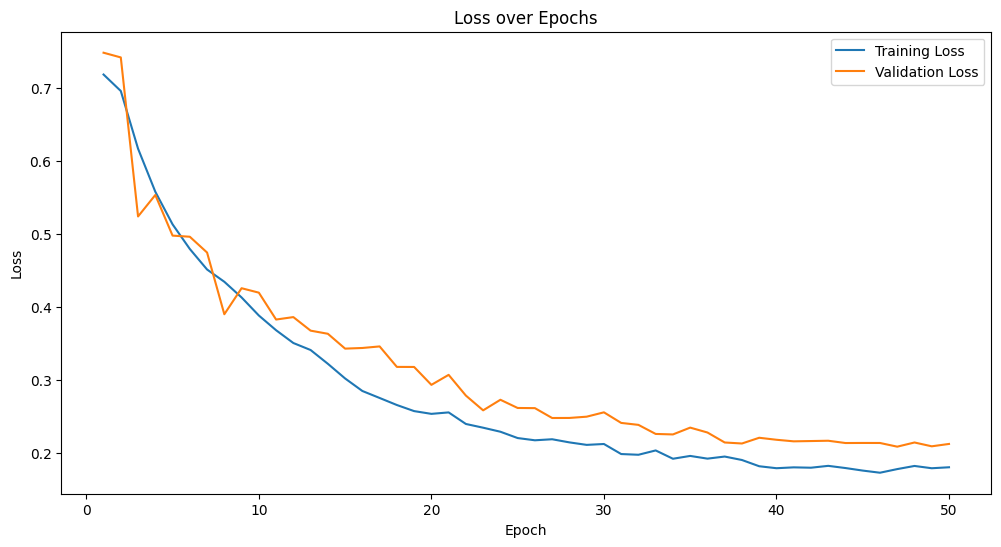

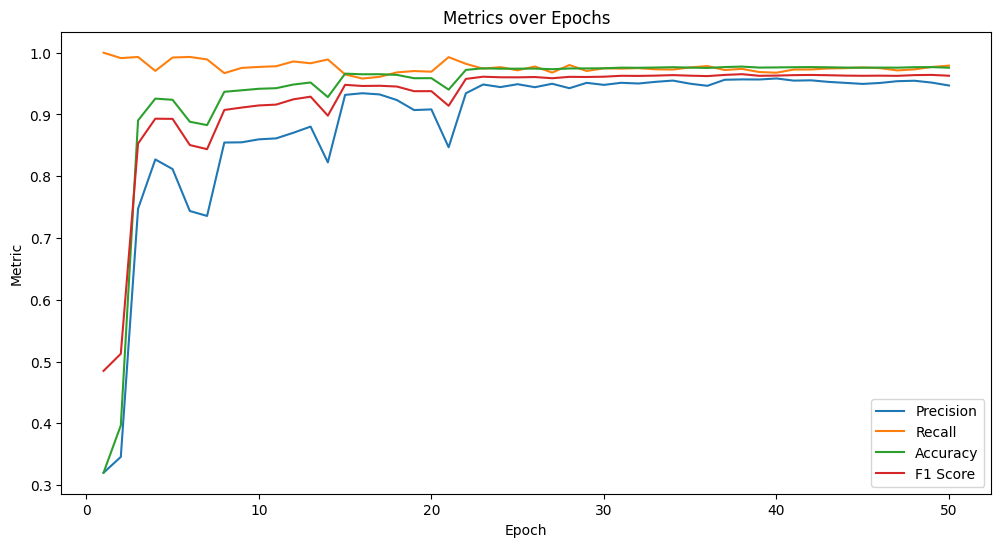

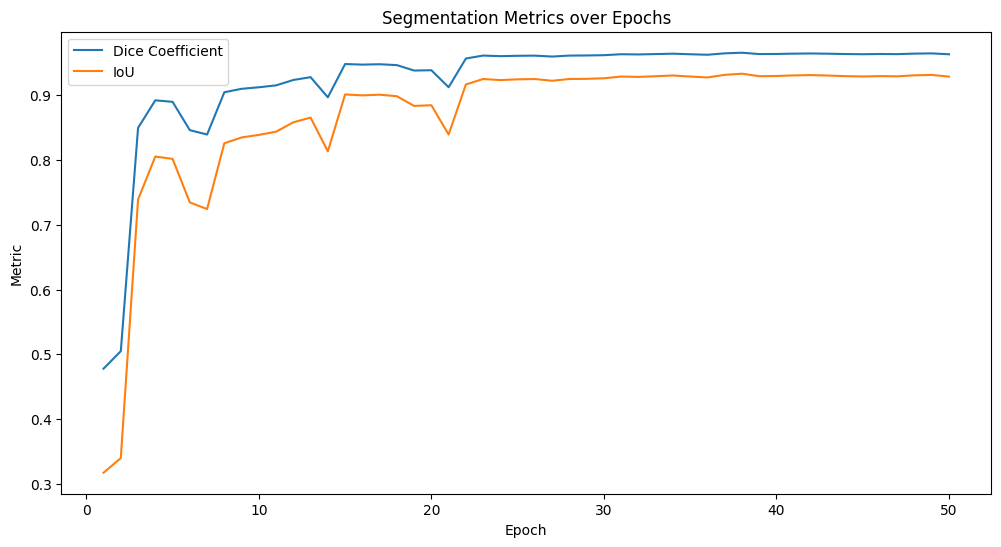

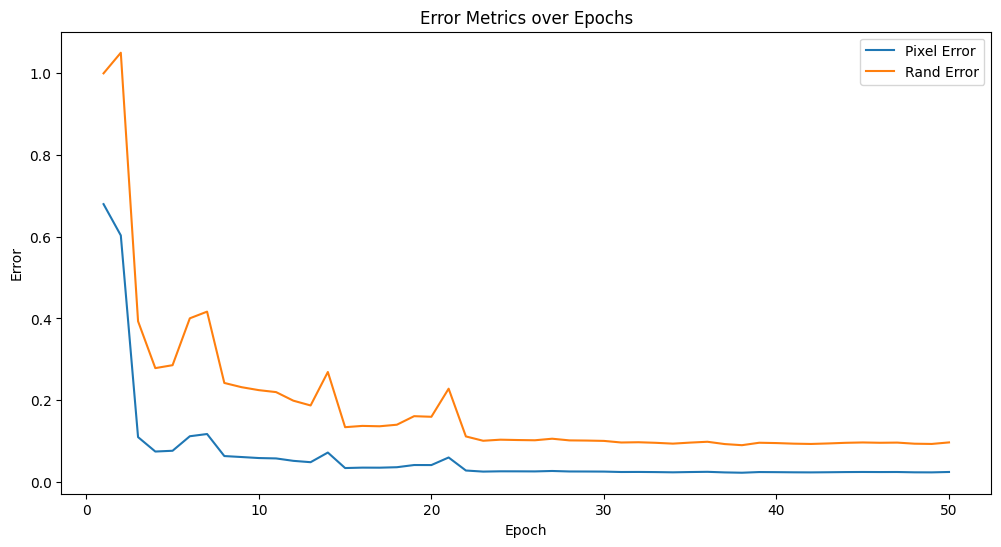

In [35]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_data, label='Training Loss')
plt.plot(epochs, val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('loss.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_data, label='Precision')
plt.plot(epochs, recall_data, label='Recall')
plt.plot(epochs, accuracy_data, label='Accuracy')
plt.plot(epochs, f1_data, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Metrics over Epochs')
plt.savefig('metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, dice_coeff_data, label='Dice Coefficient')
plt.plot(epochs, iou_data, label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Segmentation Metrics over Epochs')
plt.savefig('segmentation_metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, pixel_error_data, label='Pixel Error')
plt.plot(epochs, rand_error_data, label='Rand Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title('Error Metrics over Epochs')
plt.savefig('error_metrics.png')
plt.show()



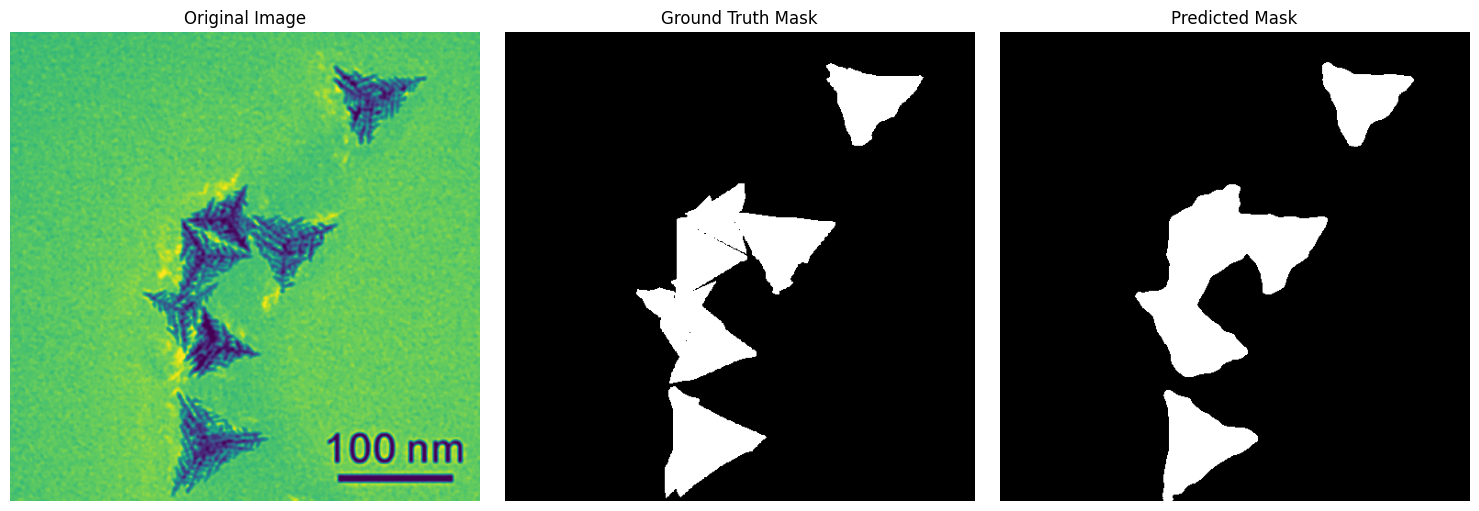

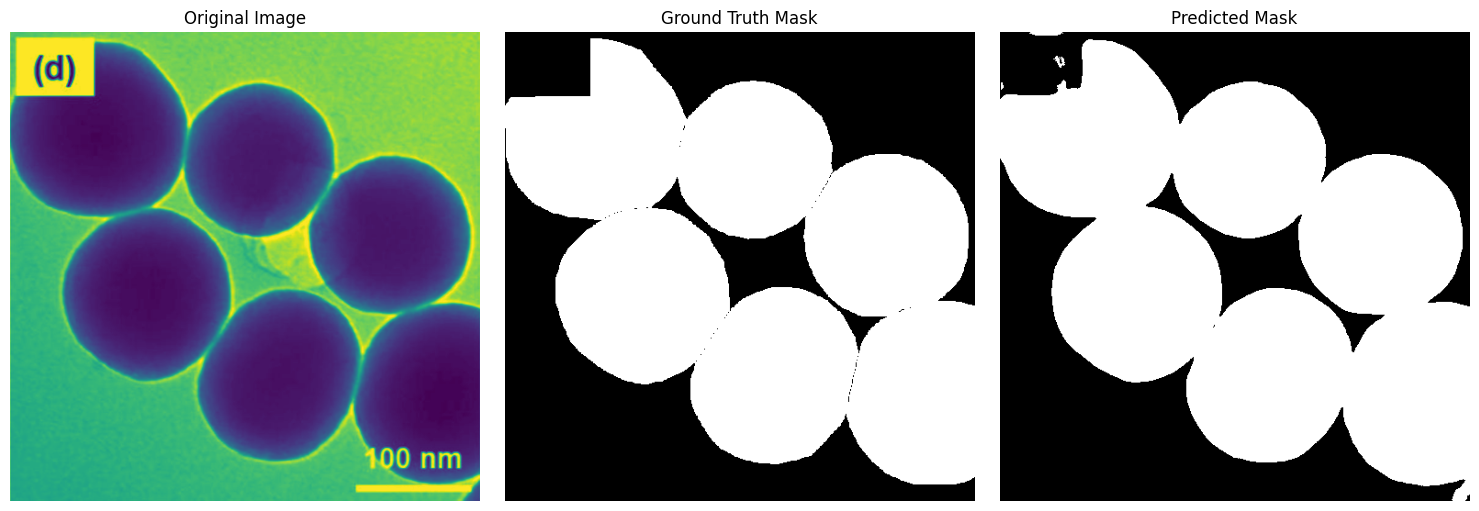

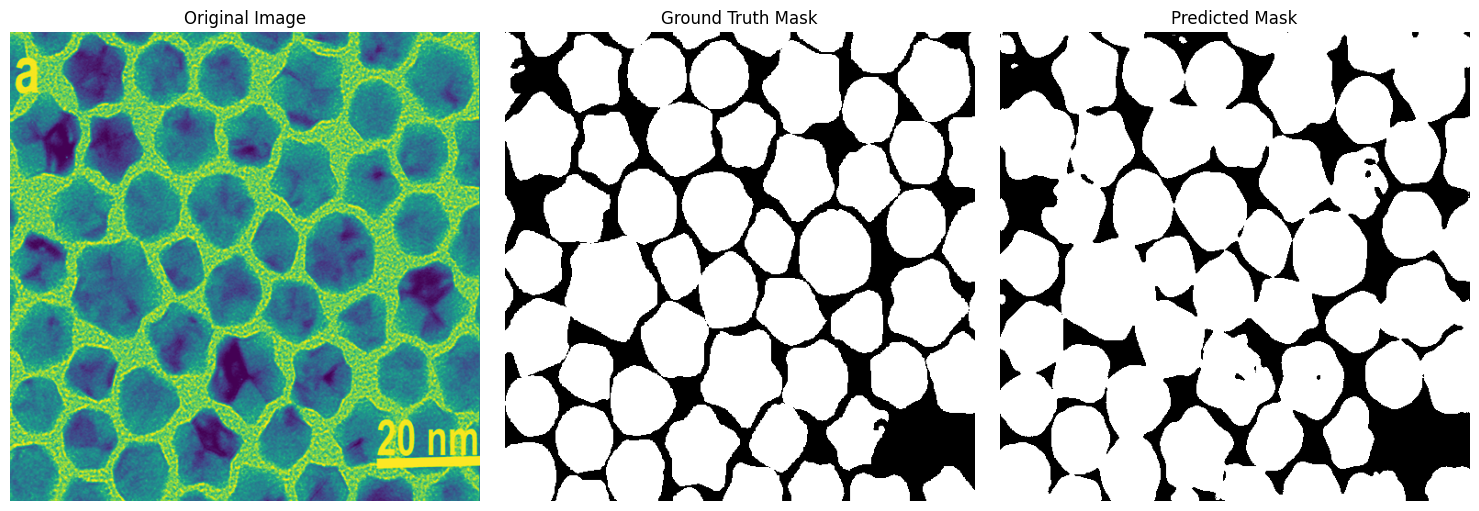

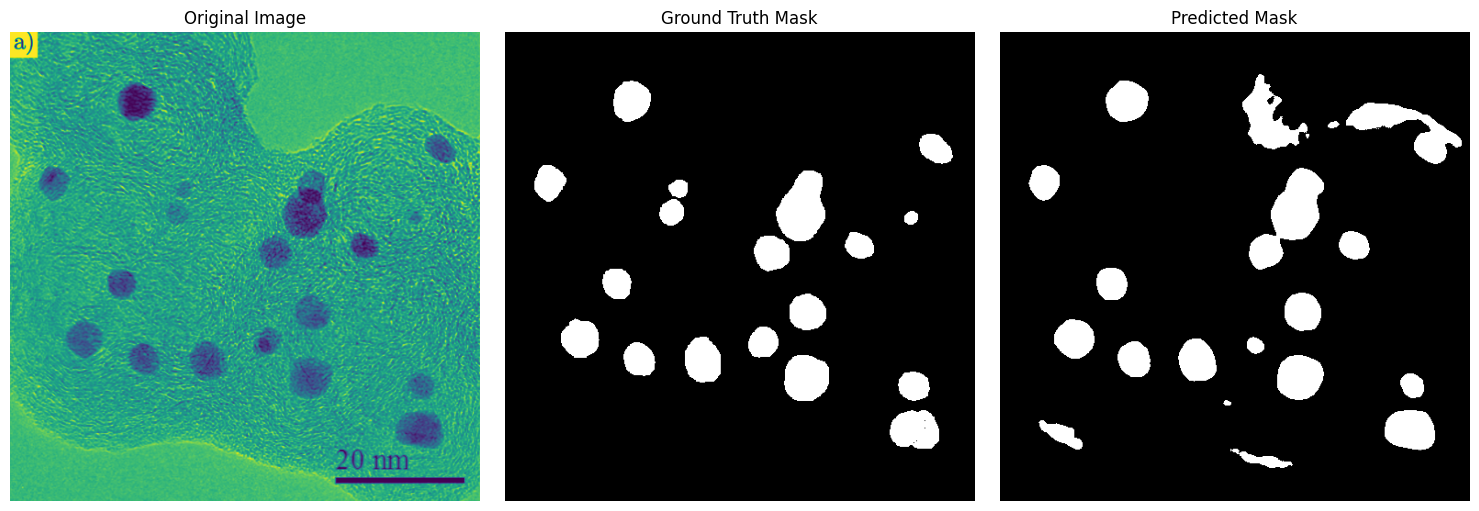

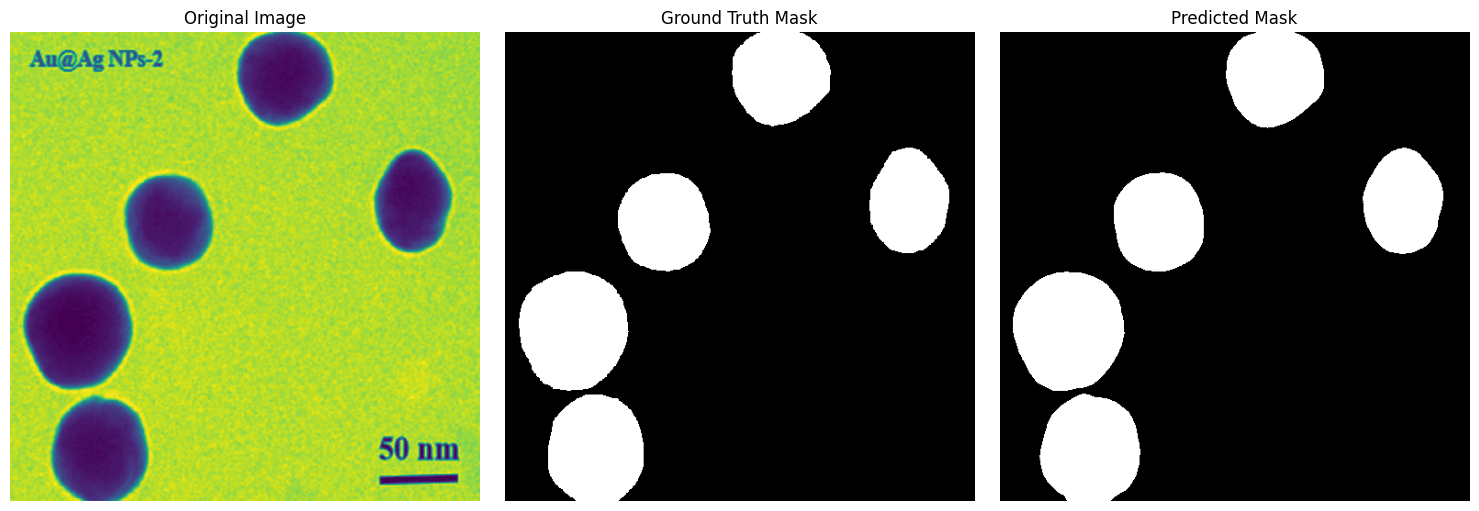

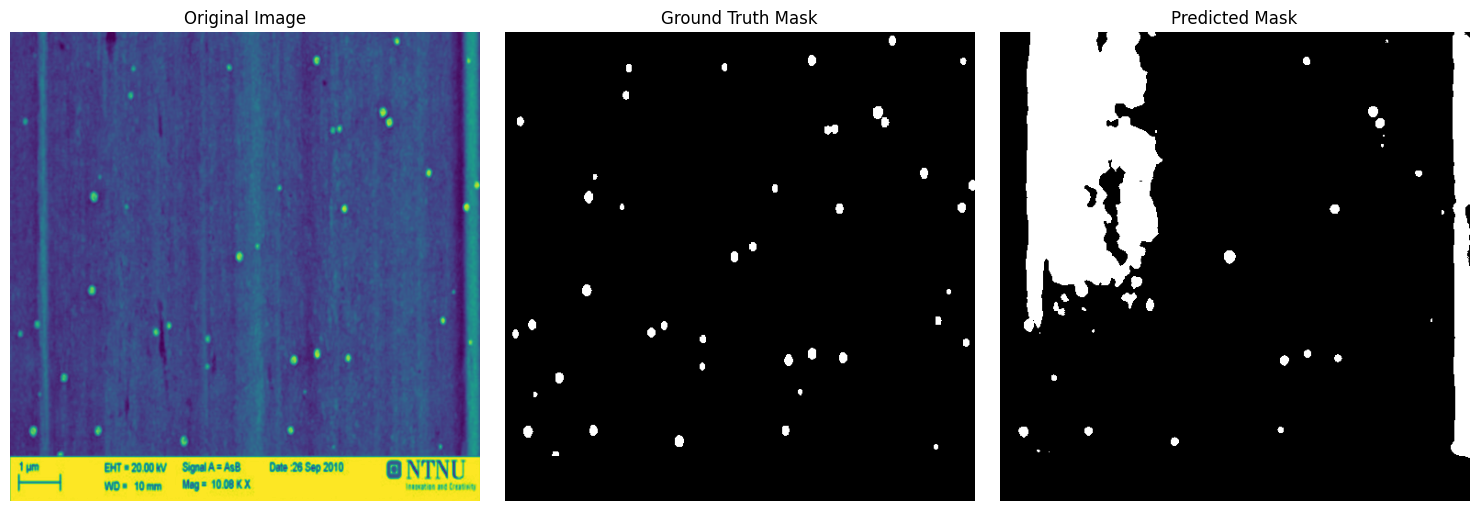

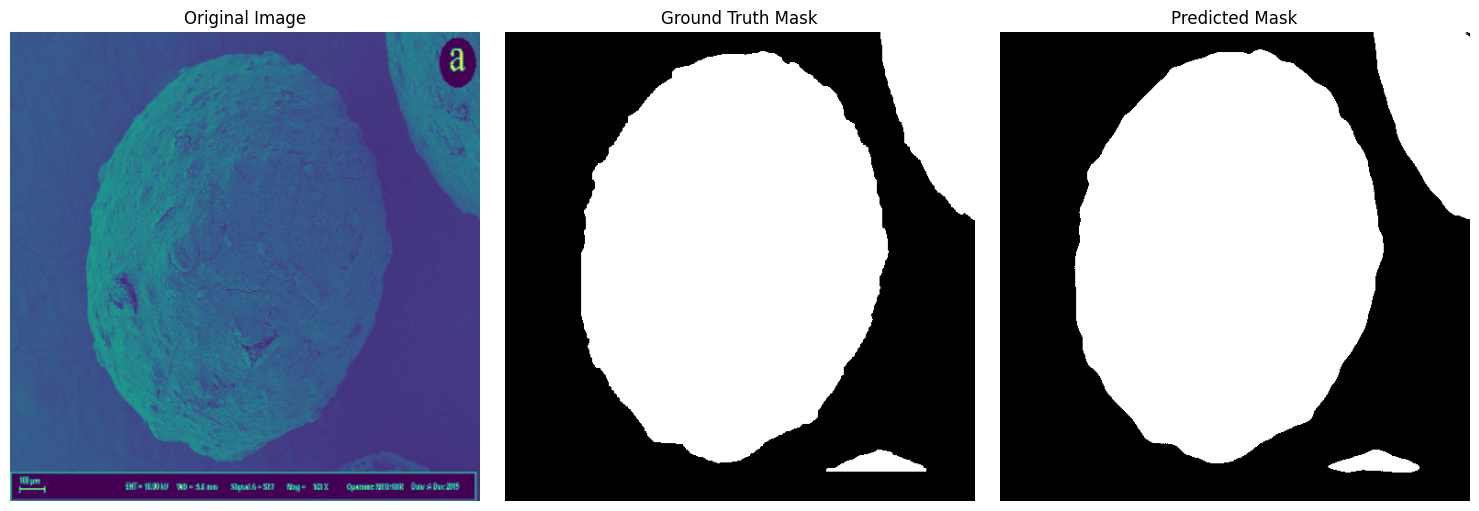

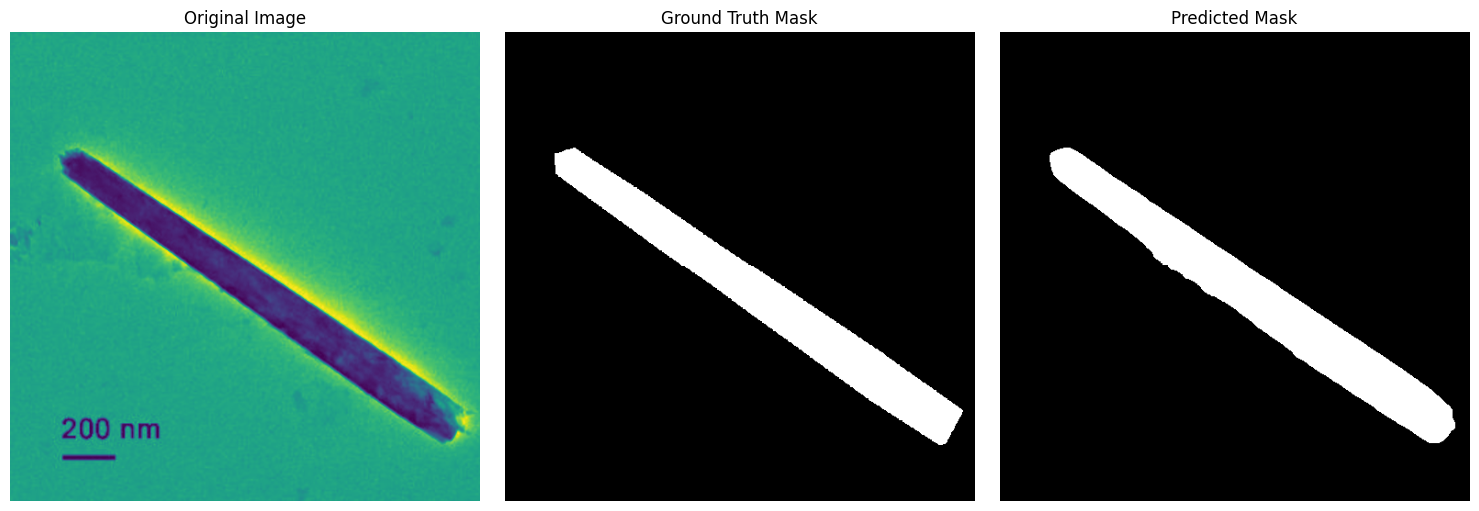

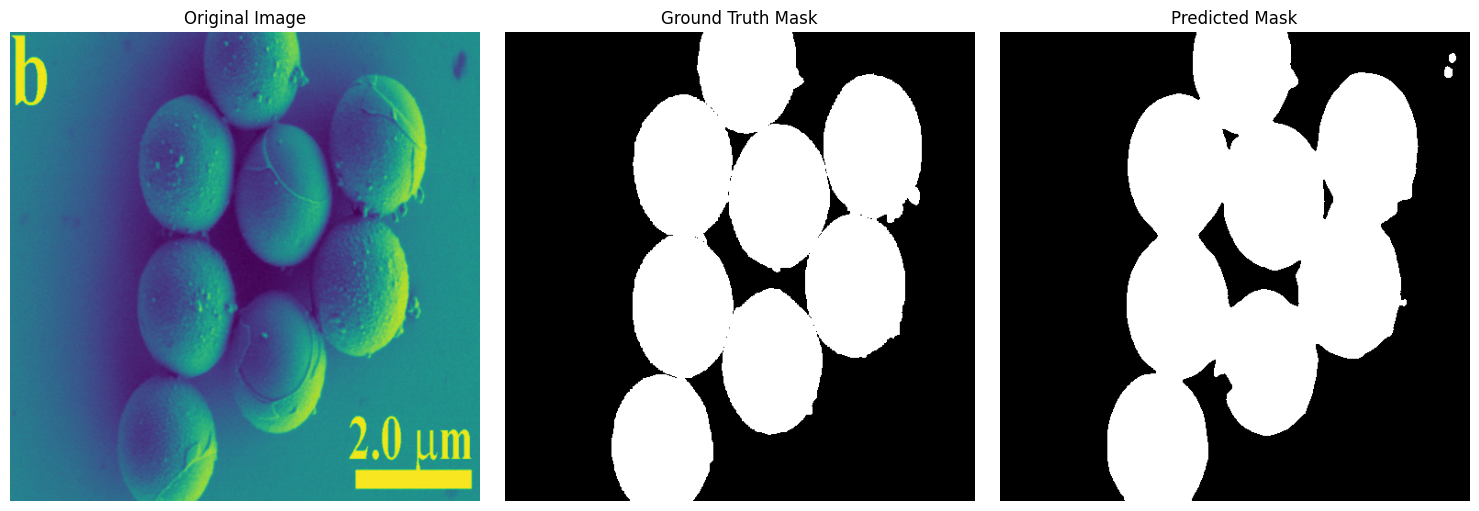

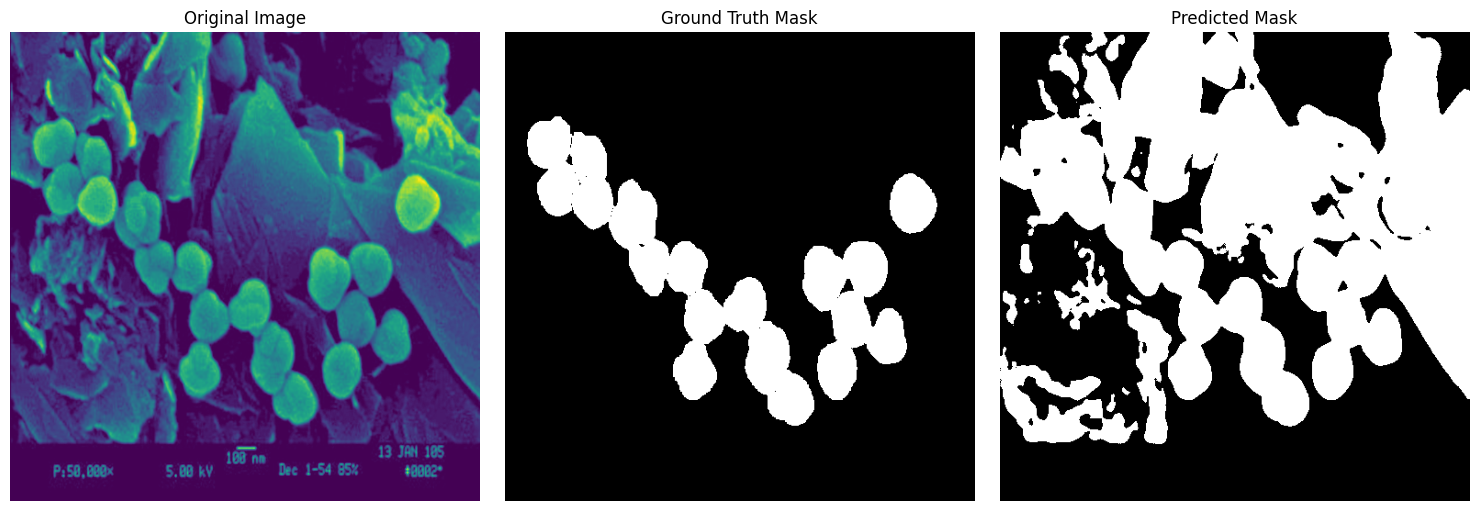

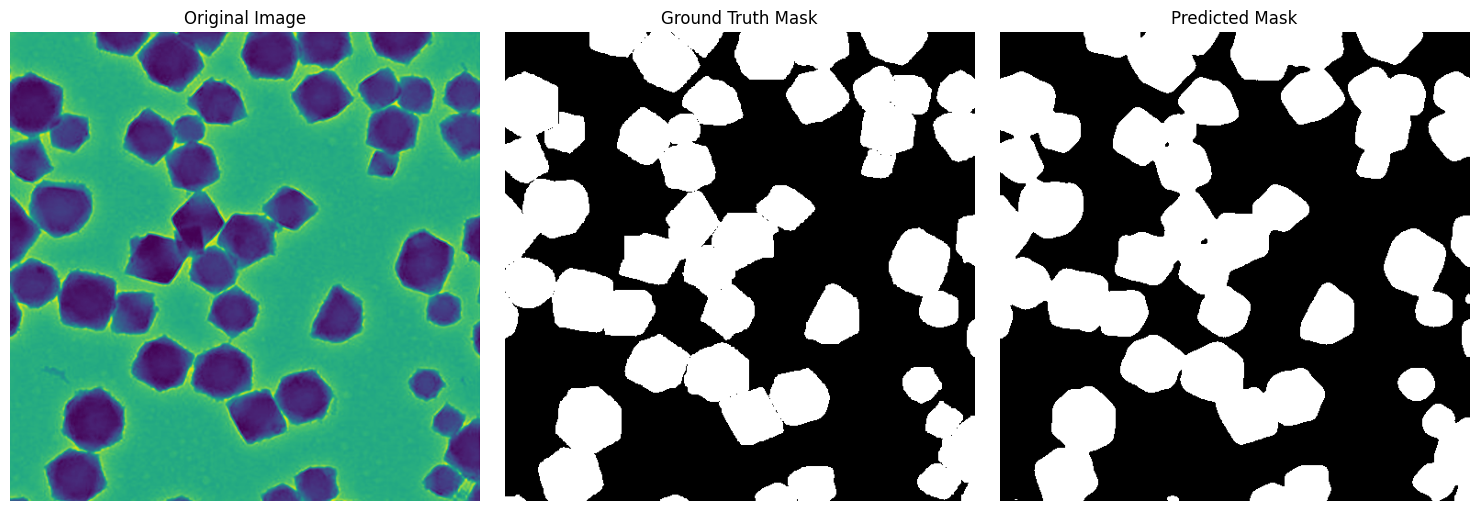

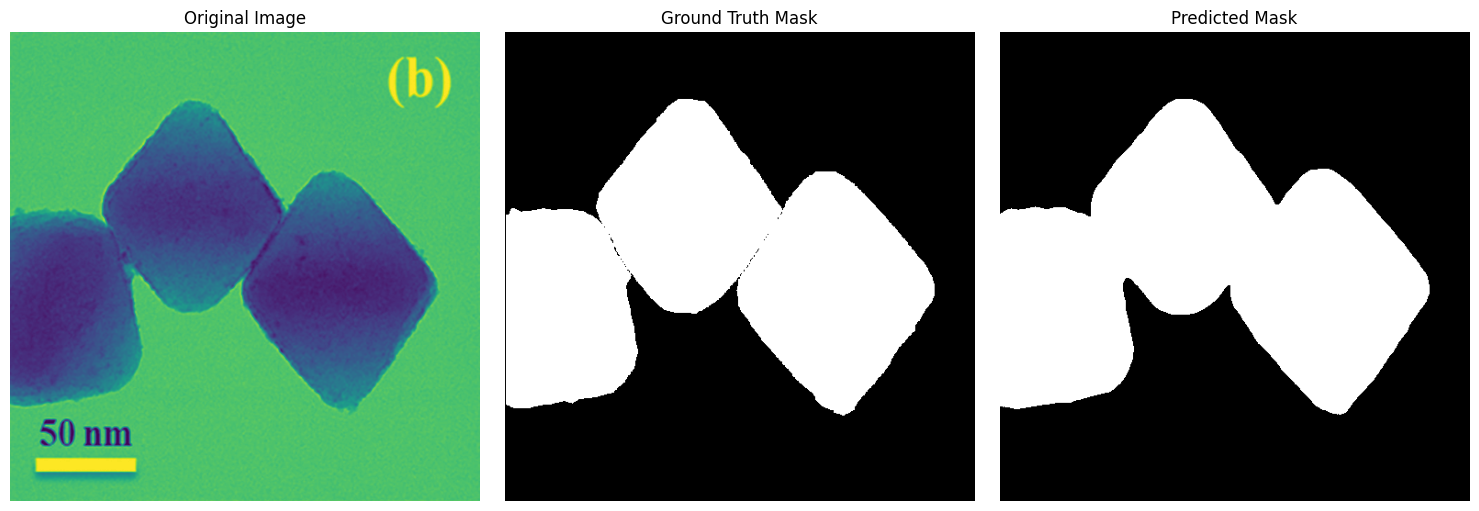

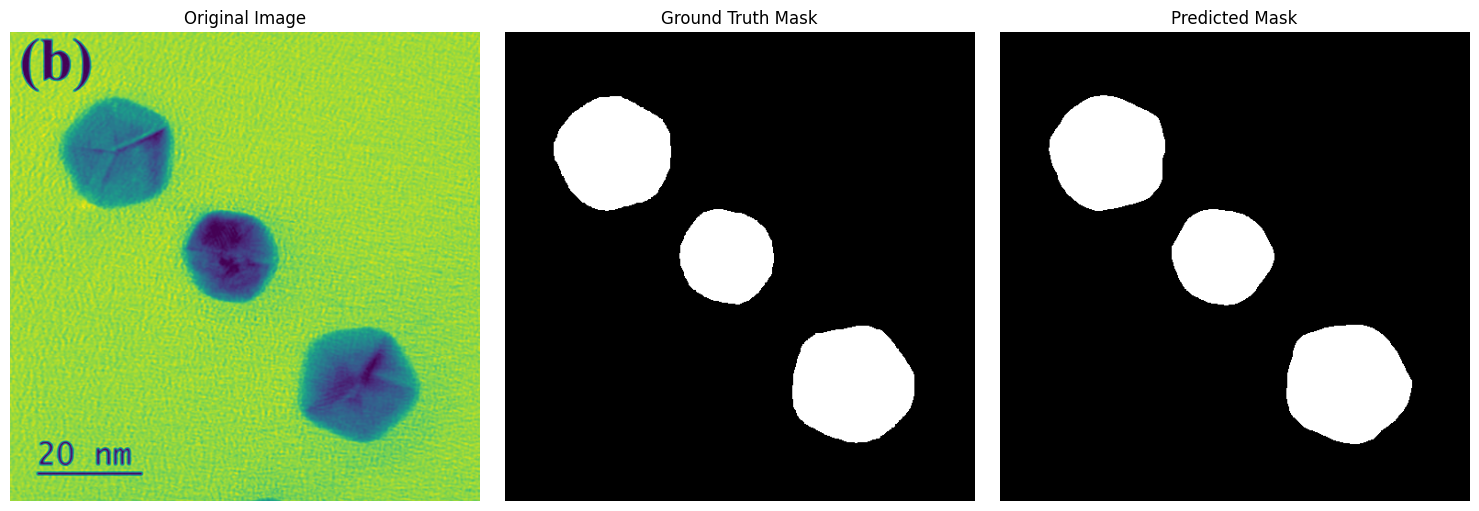

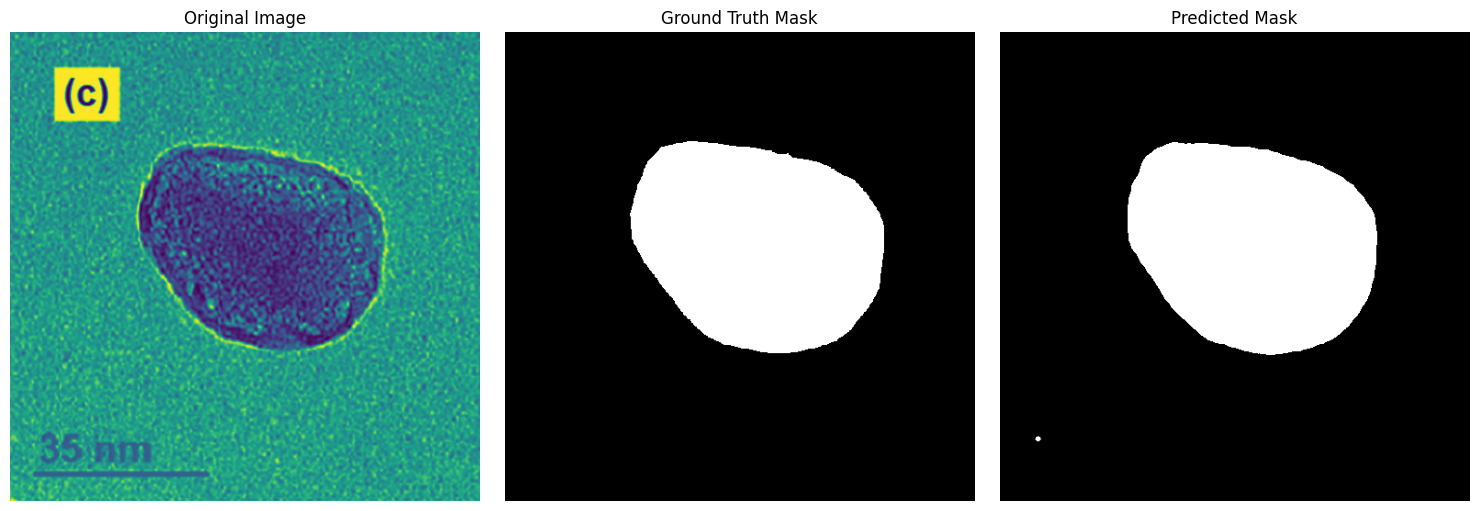

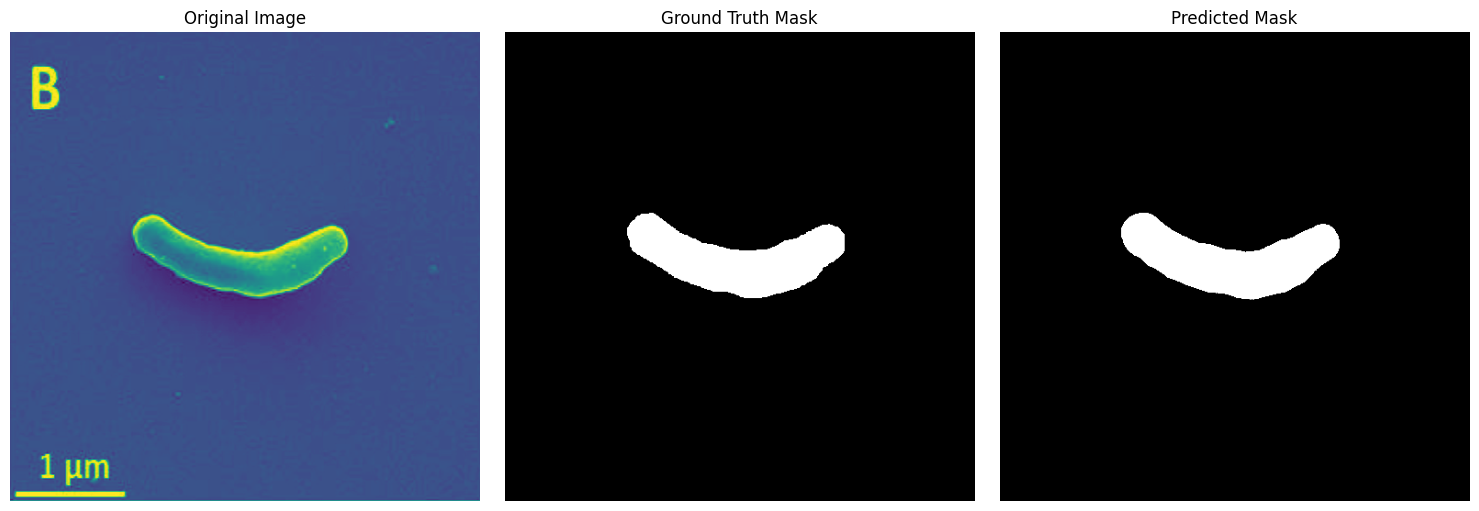

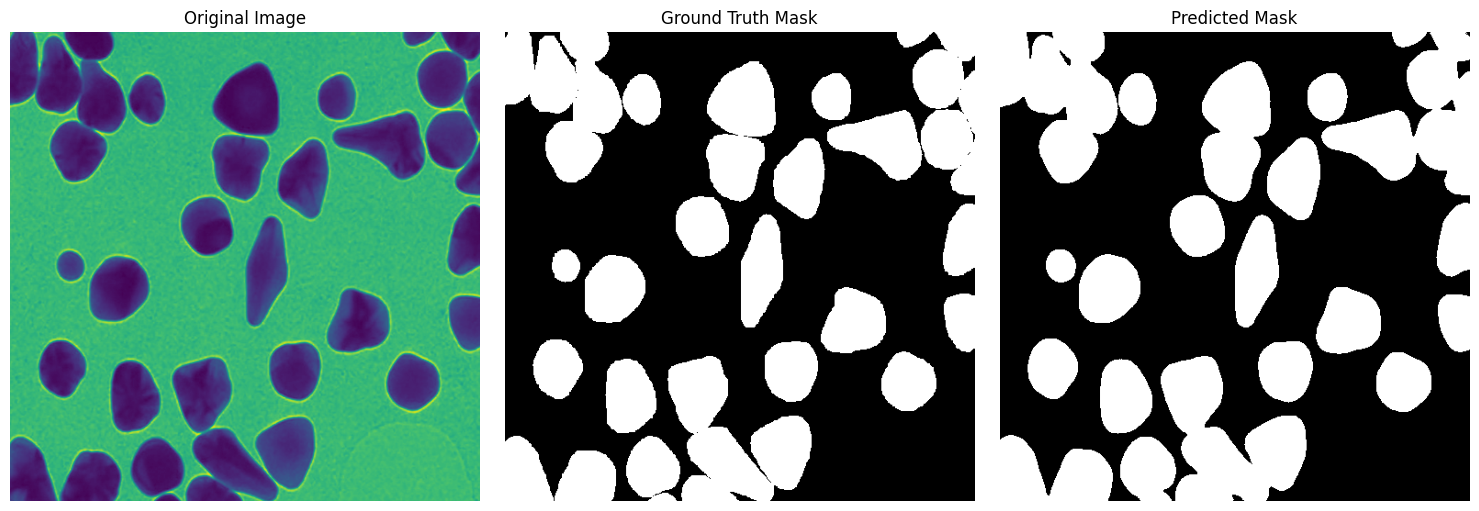

In [29]:
# Set the model to evaluation mode
model.eval()

# Get a batch of images and masks from the test loader
images, masks = next(iter(test_loader))
images = images.to(config.device)
masks = masks.to(config.device)

# Run the model on the images
with torch.no_grad():
    outputs = model(images)
    if isinstance(outputs, dict):
        outputs = outputs['out']
    outputs = outputs.squeeze(1)  # Remove channel dimension if necessary

    # Apply sigmoid activation to get probabilities between 0 and 1
    probs = torch.sigmoid(outputs)

# Threshold probabilities to get binary masks
pred_masks = (probs > 0.5).float()

# Move data to CPU and convert to NumPy arrays for plotting
images = images.cpu()
masks = masks.cpu()
pred_masks = pred_masks.cpu()

# Denormalize images for visualization if you normalized them during preprocessing
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])   # ImageNet std

batch_size = images.shape[0]

for i in range(batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    img = images[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
    #img = img * std + mean  # Denormalize
    #img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground Truth Mask
    gt_mask = masks[i].numpy()
    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted Mask
    pred_mask = pred_masks[i].numpy()
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    #plt.savefig(f"epoch_{epoch+1}_image_{i}.png")
    plt.tight_layout()
    plt.show()


In [36]:
import pandas as pd
data = {
    "epoch": epochs,
    "train_loss": train_loss_data,
    "val_loss": val_loss_data,
    "precision": precision_data,
    "recall": recall_data,
    "accuracy": accuracy_data,
    "iou": iou_data,
    "f1": f1_data,
    "dice_coeff": dice_coeff_data,
    "rand_error": rand_error_data,
    "pixel_error": pixel_error_data
}

metrics_df = pd.DataFrame(data)
print(metrics_df)
metrics_df.to_csv("training_metrics.csv", index=False)

    epoch  train_loss  val_loss  precision    recall  accuracy       iou  \
0       1    0.718310  0.748209   0.320135  1.000000  0.320135  0.317569   
1       2    0.695713  0.741752   0.345745  0.991311  0.396689  0.340123   
2       3    0.616602  0.523688   0.747495  0.993132  0.890402  0.738810   
3       4    0.557605  0.553146   0.827232  0.970611  0.925696  0.804904   
4       5    0.512890  0.497440   0.811677  0.992242  0.923816  0.801379   
5       6    0.479106  0.495870   0.743796  0.993152  0.888291  0.734301   
6       7    0.450954  0.474213   0.735798  0.989166  0.882827  0.723970   
7       8    0.434122  0.389603   0.854627  0.966960  0.936767  0.825472   
8       9    0.412643  0.425290   0.854951  0.975402  0.939148  0.834365   
9      10    0.387887  0.419207   0.859783  0.977020  0.941634  0.838323   
10     11    0.367687  0.382353   0.861315  0.978091  0.942569  0.843253   
11     12    0.350162  0.385698   0.870423  0.985857  0.948489  0.857712   
12     13   